## The Curse of Dimensionality

From the book A Geron. Let's dive in what he is trying to explain

Many Machine Learning problems involve thousands or even millions of features for each training
instance. Not only does this make training extremely slow, it can also make it much harder to find a good
solution, as we will see. This problem is often referred to as the curse of dimensionality.

Yes, it speed up the training, but it also helps in data visualization. Ploting data in 2D instead.

### Some tips
Always start training with no dimension reduction. It may damage your training. since you are taking some might be relevant information out.

All training instances actually lie within (or close to) a much lower-dimensional subspace of the
high-dimensional space. To see this, we can **project** data points on two dim axes and see how well they are represented.

### Three type of dimension reduction (most popular)
PCA, Kernel PCA, and LLE

### PCA
Principal Component Analysis (PCA) is by far the most popular dimensionality reduction algorithm.
First it identifies the hyperplane that lies closest to the data, and then it projects the data onto it.
In meaning that the variance of a given feature represent the information that it contain. The PCA method tends to minimize the loss of the variance by projecting original features on their most closest hyperplane.

there is a standard matrix factorization technique called Singular Value Decomposition (SVD) that can decompose the training set
matrix X into the dot product of three matrices U · Σ · VT, where VT contains all the principal components
that we are looking for.

In [126]:
import numpy as np

# let's create X
X=np.random.randn(10,10)
y=np.random.randn(10,1)
X_centered = X - X.mean(axis=0)                # let's center variables first
U, s, V = np.linalg.svd(X_centered)            # Now we can use SVD to construct the correlation matrix
c1 = V.T[:, 0] 
c2 = V.T[:, 1]
np.corrcoef(c1,c2) # we can show that c1 and c2 are not correlated


array([[ 1.        ,  0.04775913],
       [ 0.04775913,  1.        ]])

PCA assumes that the dataset is centered around the origin. As we will see, **Scikit-Learn**’s PCA classes take care of centering the data for you. However, if you implement PCA yourself (as in the preceding example), or if you use other libraries, don’t forget to **center** the data first.

Here let's project the training set onto the plane defined by the first two principal components

In [127]:
W2 = V.T[:, :2]
X2D = X_centered.dot(W2) 

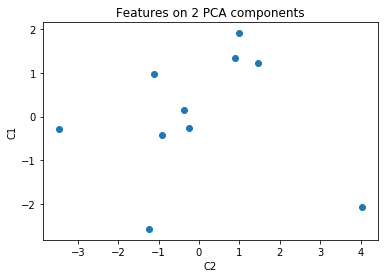

In [128]:
import matplotlib.pyplot as plt
plt.scatter(X2D[:,0], X2D[:,1])
plt.title('Features on 2 PCA components')
plt.ylabel('C1')
plt.xlabel('C2')
plt.savefig('PCA.png')
plt.show()

#### Using Scikit-Learn
Scikit-Learn’s PCA class implements PCA using **SVD** decomposition just like we did before. The
following code applies PCA to reduce the dimensionality of the dataset down to two dimensions (note
that it **automatically takes care of centering the data**)

In [129]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3) # choose the number of component to keep
#X2D0 = pca.fit_transform(X)
# pca.components_.T[:, 0] # not working 
# print(pca.explained_variance_ratio_) # the explained variance ratios of the first two components of the 3D dataset

There are many ways to choose the right number PC.
You can still do the decompose above and then compute cumsum to see if your explained information amount is met.

The following code computes PCA without reducing dimensionality, then computes the minimum number
of dimensions required to preserve 95% of the training set’s variance.

In [130]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d
cumsum

array([ 0.39737359,  0.60848519,  0.75978331,  0.8630683 ,  0.93588576,
        0.96423609,  0.98624802,  0.99950901,  1.        ,  1.        ])

You could then set **n_components**=d and run PCA again.
However, there is a much better option: instead of specifying the number of principal components you want to preserve, you can set **n_components** to be a **float between 0.0 and 1.0**, indicating the **ratio of variance** you wish to preserve

In [67]:
pca = PCA(n_components=0.95)
#pca = PCA(n_components=d)
X_reduced = pca.fit_transform(X)

It is also possible to **decompress** the reduced a dataset back to its original dimensions by applying the **inverse
transformation** of the PCA projection. Of course this won’t give you back the original data, since the **projection** lost a bit of information (within the 5% variance that was dropped), but it will likely be quite close to the original data. The mean squared distance between the original data and the reconstructed data (compressed and then decompressed) is called the **reconstruction error**

An example below with the compression of MNIST data from 784 to 150 to keep 95% of information.

In [80]:
# Let's start by fetching the data
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
X_mnist=mnist.data
#X_mnist.target.shape
#np.unique(mnist.target).size

In [81]:
pca = PCA(n_components = 154)
X_mnist_reduced = pca.fit_transform(X_mnist)
X_mnist_recovered = pca.inverse_transform(X_mnist_reduced)

In [86]:
print("The new PCA associated data of MNIST's shape is : " +  str(X_mnist_reduced.shape))
print("The Recovered back data of MNIST  shape is : " +  str(X_mnist_recovered.shape))

The new PCA associated data of MNIST's shape is : (70000, 154)
The Recovered back data of MNIST  shape is : (70000, 784)


**Incremental PCA** for large Data Set or online/ Streaming data dimension reduction.
We do it through **mini-batches** : you can split the training set into mini-batches and feed an IPCA algorithm one minibatch
at a time.

The following code splits the MNIST dataset into 100 mini-batches (using NumPy’s array_split()
function) and feeds them to Scikit-Learn’s IncrementalPCA class5 to reduce the dimensionality of the
MNIST dataset down to 154 dimensions (just like before). Note that you must call the **partial_fit()**
method with each **mini-batch** rather than the **fit()** method with the whole training set:

In [87]:
from sklearn.decomposition import IncrementalPCA
n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_mnist, n_batches):
    inc_pca.partial_fit(X_batch)
    X_mnist_reduced = inc_pca.transform(X_mnist)   

In [88]:
X_mnist_reduced.s

(70000, 154)

Using the numpy memmap help us to use **fit()** . This module helps use disk binary data as if they were in memory. 

X_mm = np.memmap(X_mnist, dtype="float32", mode="readonly", shape=)
batch_size = 100 // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

**Randomized PCA**
Scikit-Learn offers yet another option to perform PCA, called Randomized PCA. This is a stochastic algorithm that quickly finds an approximation of the first d principal components. Its computational complexity is O(m × d2) + O(d3), instead of O(m × n2) + O(n3), so it is dramatically faster than the previous algorithms when d is much smaller than n.

In [131]:
from sklearn.decomposition import RandomizedPCA 
rnd_pca = RandomizedPCA(n_components=154)
X_reduced = rnd_pca.fit_transform(X_mnist)

C:\Users\kbalde\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


### Kernel PCA

We use Kernel Tricks to decrease the dimension. It means like in SVM, using high dim poly without really implementing them. making it possible to perform complex nonlinear projections for dimensionality reduction. This is called **Kernel PCA (kPCA)**.

In [132]:
from sklearn.decomposition import KernelPCA
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

### Selecting a Kernel and Tuning Hyperparameters
As kPCA is an unsupervised learning algorithm, there is no obvious performance measure to help you
select the best kernel and hyperparameter values. However, dimensionality reduction is often a
preparation step for a supervised learning task (e.g., classification), so you can simply use grid search to
select the kernel and hyperparameters that lead to the best performance on that task. For example, the
following code creates a two-step pipeline, first reducing dimensionality to two dimensions using kPCA,
then applying Logistic Regression for classification. Then it uses GridSearchCV to find the best kernel
and gamma value for kPCA in order to get the best classification accuracy at the end of the pipeline:
We can list three kernel type model for PCA : 
- Linear Kernel: it is like using normal PCA
-  RBF Kernel ( Radian Biased Function)
- Sigmoid Kernel (Logistic)

In [133]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
clf = Pipeline([
("kpca", KernelPCA(n_components=2)),
("log_reg", LogisticRegression())
])
param_grid = [{
"kpca__gamma": np.linspace(0.03, 0.05, 10),
"kpca__kernel": ["rbf", "sigmoid"]
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
#grid_search.fit(X, y)
#print(grid_search.best_params_)
#  {'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}
# Now use gamma to do your KernelPCA

In [108]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

You may be wondering how to perform this **reconstruction**. One solution is to train a supervised
regression model, with the projected instances as the training set and the original instances as the targets.
Scikit-Learn will do this automatically if you set **fit_inverse_transform=True**, as shown in the
following code

In [109]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

By default, fit_inverse_transform=False and KernelPCA has no inverse_transform() method. This method only gets
created when you set fit_inverse_transform=True.

In [110]:
#You can then compute the reconstruction pre-image error:
from sklearn.metrics import mean_squared_error
mean_squared_error(X, X_preimage)
# 32.786308795766132

0.83599220256337026

Now you can use grid search with cross-validation to find the kernel and hyperparameters that minimize
this pre-image reconstruction error.

### LLE
**Locally Linear Embedding** (**LLE**) is another very powerful **nonlinear dimensionality reduction**
(**NLDR**) technique. It is a Manifold Learning technique that does not rely on projections like the previous algorithms. In a nutshell, LLE works by first measuring how each training instance linearly relates to its closest neighbors (c.n.), and then looking for a low-dimensional representation of the training set where these local relationships are best preserved (more details shortly).

This makes it particularly good at
unrolling twisted manifolds, especially when there is not too much noise

In [124]:
# try it with the swiss roll data
#from sklearn.datasets import make_swiss_roll
#X=make_swiss_roll(100)
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=8)
#X_reduced = lle.fit_transform(X)

### Other Dimensionality Reduction Techniques
There are many other dimensionality reduction techniques, several of which are available in Scikit-Learn.
Here are some of the most popular:
- **Multidimensional Scaling (MDS)** reduces dimensionality while trying to preserve the distances between the instances. 
- **Isomap** creates a graph by connecting each instance to its nearest neighbors, then reduces dimensionality while trying to preserve the geodesic distances between the instances. 
- **t-Distributed Stochastic Neighbor Embedding (t-SNE)** reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. It is mostly used for visualization, in particular to visualize clusters of instances in high-dimensional space (e.g., to visualize the MNIST
images in 2D).
- **Linear Discriminant Analysis (LDA)** is actually a classification algorithm, but during training it
learns the most discriminative axes between the classes, and these axes can then be used to define a
hyperplane onto which to project the data. The benefit is that the projection will keep classes as far
apart as possible, so LDA is a good technique to reduce dimensionality before running another classification algorithm such as an SVM classifier.
